In [13]:
import numpy as np
import pandas as pd
#
import statsmodels.api as sm

#我们希望多个自变量之间彼此不相关，我们希望自变量与因变量相关。
#导入库 - 用来计算方差膨胀因子，多重共线性
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

#导入sklearn,对数据进行预处理，然后快速训练拆分，最后拟合线性回归模型，计算得分
from sklearn.preprocessing import StandardScaler #数据预处理-标准化
from sklearn.model_selection import train_test_split #快速训练拆分
from sklearn.linear_model import LinearRegression #线性回归模型
from sklearn.metrics import r2_score 

#使用sklearn中的波士顿房屋数据
from sklearn.datasets import load_boston

#绘图
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(42)

boston_data = load_boston()
df = pd.DataFrame()
df['MedianHomePrice'] = boston_data.target
df2 = pd.DataFrame(boston_data.data)
df2.columns = boston_data.feature_names
df = df.join(df2)
df.head()

,MedianHomePrice,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


你将要用到 notebook 的 **df** 数据帧。你可以在 [这里](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) 找到数据集中关于特征的描述。具体而言，你将尝试使用数据集中的其他变量来构建最佳模型以预测平均房价。 

# 探索变量

<li>CRIM - per capita crime rate by town
<li>ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
<li>INDUS - proportion of non-retail business acres per town.
<li>CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
<li>NOX - nitric oxides concentration (parts per 10 million)
<li>RM - average number of rooms per dwelling
<li>AGE - proportion of owner-occupied units built prior to 1940
<li>DIS - weighted distances to five Boston employment centres
<li>RAD - index of accessibility to radial highways
<li>TAX - full-value property-tax rate per $10,000
<li>PTRATIO - pupil-teacher ratio by town
<li>B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
<li>LSTAT - % lower status of the population

`1.` 使用 [train test_split](http://scikit-learn.org/stable/modules/cross_validation.html) 创建一个 training 数据集与一个 test 数据集，其中20％的数据在 test 数据集中。无序状态设为0。将结果存储在 `X_train, X_test, y_train, y_test` 中。

除非指定，否则只能使用 `X_train` 与 `y_train` 变量来回答以下问题。

In [124]:
X=df[[ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y=df["MedianHomePrice"]

#X_train  is the training data set.
#y_train  is the set of labels to all the data in X_train.
#X_test =  is the test data set.
#y_test = is the set of labels to all the data in X_test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

`2.` 首先，获取数据集中每个特征的汇总。使用汇总的结果回答下面的第一个与第二个测试题目。同样，使用 [corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) 方法对每个变量进行相互比较。

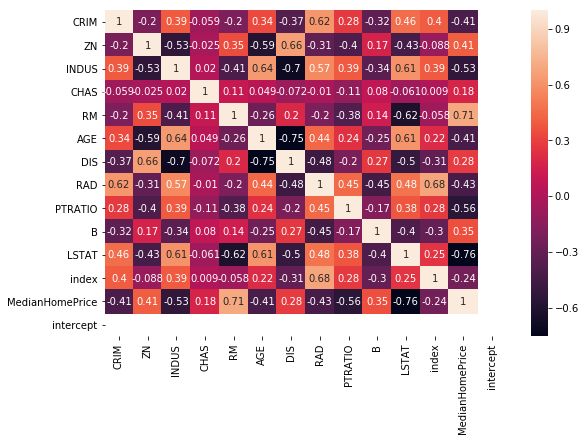

In [166]:
plt.subplots(figsize=(9, 6))
sns.heatmap(training_data.corr(),annot=True);

`3.` 接下来，使用 [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) 来缩放数据集中的所有 x 变量。将结果存储在 `X_scaled_train` 中。 创建一个 pandas 数据帧并存储缩放的 x 变量以及 training 响应。把该数据帧命名为 `training_data` 。

In [141]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)

#Create DataFrame - training_data
training_data = pd.DataFrame(X_scaled_train,columns=X_train.columns)
training_data = training_data.join(y_train.reset_index())

In [142]:
training_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,index,MedianHomePrice
0,-0.369848,-0.499608,-0.704925,3.664502,-0.424879,0.935678,0.693669,-0.437218,-0.162242,-0.561656,-0.484638,0.371691,-0.411000,220,26.7
1,-0.394393,-0.499608,-0.044878,-0.272888,-1.241859,-0.491181,-1.835528,0.730055,-0.624648,-0.573376,0.336491,0.205012,-0.387681,71,21.7
2,-0.399992,0.771168,-0.886760,-0.272888,-1.111490,0.857849,-0.524621,1.234769,-0.393445,-0.602677,-0.849584,0.366609,-0.181919,240,22.0
3,-0.403071,0.029882,-0.465819,-0.272888,-0.277127,-0.417676,-0.086464,0.861527,-0.509046,-0.538216,-1.488240,0.415732,-0.037886,6,22.9
4,2.780373,-0.499608,0.998884,-0.272888,1.070021,-1.438097,0.715042,-1.021528,1.687378,1.542121,0.792674,-2.613393,1.911362,417,10.4


`3.` 接下来，记得用 **所有的** 缩放特征来拟合线性模型，以预测此响应（平均房价）。不要忘记添加一个截距。使用你的线性模型的结果来回答下面的第三个测试题目。

In [143]:
training_data["intercept"]=1
lm=sm.OLS(training_data["MedianHomePrice"],
          training_data[["intercept",'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']])
results=lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MedianHomePrice   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     102.1
Date:                Thu, 17 May 2018   Prob (F-statistic):          9.99e-117
Time:                        12:42:26   Log-Likelihood:                -1171.5
No. Observations:                 404   AIC:                             2371.
Df Residuals:                     390   BIC:                             2427.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.6119      0.223    101.567      0.000      22.174      23.050
CRIM          -0.9616      0.296     -3.246      0.001      -1.544      -0.379
ZN             1.0566      0.341      3.100      0.002       0.387       1.727
INDUS          0.0409      0.443      0.092      0.926      -0.830       0.912
CHAS           0.5949      0.229      2.596      0.010       0.144       1.045
NOX           -1.8597      0.485     -3.837      0.000      -2.813      -0.907
RM             2.5681      0.317      8.090      0.000       1.944       3.192
AGE           -0.0855      0.402     -0.213      0.832      -0.876       0.705
DIS           -2.8815      0.445     -6.480      0.000      -3.756      -2.007
RAD            2.1088      0.607      3.475      0.001       0.916       3.302
TAX           -1.8746      0.665     -2.818      0.005      -3.183      -0.567
PTRATIO       -2.2951      0.300     -7.643      0.000      -2.886      -1.705
B              0.7279      0.261      2.786      0.006       0.214       1.242
LSTAT         -3.5986      0.395     -9.108      0.000      -4.375      -2.822
==============================================================================
Omnibus:                      141.470   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              628.301
Skew:                           1.470   Prob(JB):                    3.68e-137
Kurtosis:                       8.355   Cond. No.                         9.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`4.` 现在，使用下面的函数来计算数据集中每个 x_variable 的 vif，并使用该函数的结果来回答下面的第四个测试题目。

In [113]:
def vif_calculator(df, response):
    '''
    INPUT:
    df - a dataframe holding the x and y-variables
    response - the column name of the response as a string
    OUTPUT:
    vif - a dataframe of the vifs
    '''
    df2 = df.drop(response, axis = 1, inplace=False)
    features = "+".join(df2.columns)
    y, X = dmatrices(response + ' ~' + features, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    vif = vif.round(1)
    return vif

In [148]:
vif_calculator(training_data,"MedianHomePrice")

D:\Users\Alexander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,0.0,Intercept
1,1.8,CRIM
2,2.4,ZN
3,4.0,INDUS
4,1.1,CHAS
5,4.7,NOX
6,2.0,RM
7,3.3,AGE
8,4.0,DIS
9,7.8,RAD


In [154]:
training_data_copy = training_data
training_data_copy.drop(columns=['TAX', 'NOX'],inplace=True)

ValueError: labels ['TAX' 'NOX'] not contained in axis

In [155]:
vif_calculator(training_data_copy,"MedianHomePrice")

D:\Users\Alexander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,0.0,Intercept
1,1.8,CRIM
2,2.3,ZN
3,2.8,INDUS
4,1.0,CHAS
5,2.0,RM
6,3.0,AGE
7,3.7,DIS
8,3.4,RAD
9,1.6,PTRATIO


`5.` 根据查看 p 值和 VIF 的结果，确定删除 `AGE`、 `NOX` 与 `TAX` ，之后重新开始。用这些已删除的特征（但仍然带有截距）来拟合一个新的线性模型。使用这个线性模型和先期模型的结果来回答下面的第五个测试题目。

In [156]:
training_data["intercept"]=1
lm=sm.OLS(training_data["MedianHomePrice"],
          training_data[["intercept",'CRIM', 'ZN', 'INDUS', 'CHAS', 'RM','DIS', 'RAD', 'PTRATIO', 'B', 'LSTAT']])
results=lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MedianHomePrice   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     122.8
Date:                Thu, 17 May 2018   Prob (F-statistic):          2.71e-114
Time:                        12:52:29   Log-Likelihood:                -1184.8
No. Observations:                 404   AIC:                             2392.
Df Residuals:                     393   BIC:                             2436.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.6119      0.229     98.650      0.000      22.161      23.063
CRIM          -0.8745      0.304     -2.874      0.004      -1.473      -0.276
ZN             0.9663      0.338      2.861      0.004       0.302       1.631
INDUS         -1.1035      0.381     -2.895      0.004      -1.853      -0.354
CHAS           0.6852      0.234      2.925      0.004       0.225       1.146
RM             2.6867      0.319      8.411      0.000       2.059       3.315
DIS           -2.1124      0.403     -5.246      0.000      -2.904      -1.321
RAD            0.1670      0.362      0.462      0.644      -0.544       0.878
PTRATIO       -1.9592      0.292     -6.705      0.000      -2.534      -1.385
B              0.7874      0.267      2.947      0.003       0.262       1.313
LSTAT         -3.8684      0.375    -10.302      0.000      -4.607      -3.130
==============================================================================
Omnibus:                      141.386   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              640.171
Skew:                           1.462   Prob(JB):                    9.74e-140
Kurtosis:                       8.430   Cond. No.                         4.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`6.` 给出之前的线性回归模型的结果，从模型中删除 `RAD` 变量。然后仔细检查所有的 VIF 是否小于4。所有的变量现在应该显示与响应的具有的线性关系，并且与先前模型相比，Rsquared 值没有发生变化。

In [157]:
training_data["intercept"]=1
lm=sm.OLS(training_data["MedianHomePrice"],
          training_data[["intercept",'CRIM', 'ZN', 'INDUS', 'CHAS', 'RM','DIS', 'PTRATIO', 'B', 'LSTAT']])
results=lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MedianHomePrice   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     136.6
Date:                Thu, 17 May 2018   Prob (F-statistic):          2.50e-115
Time:                        12:53:18   Log-Likelihood:                -1184.9
No. Observations:                 404   AIC:                             2390.
Df Residuals:                     394   BIC:                             2430.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.6119      0.229     98.748      0.000      22.162      23.062
CRIM          -0.8123      0.273     -2.980      0.003      -1.348      -0.276
ZN             0.9811      0.336      2.920      0.004       0.321       1.642
INDUS         -1.0628      0.371     -2.869      0.004      -1.791      -0.334
CHAS           0.6905      0.234      2.955      0.003       0.231       1.150
RM             2.7053      0.317      8.546      0.000       2.083       3.328
DIS           -2.1343      0.399     -5.343      0.000      -2.920      -1.349
PTRATIO       -1.9158      0.276     -6.930      0.000      -2.459      -1.372
B              0.7565      0.258      2.927      0.004       0.248       1.265
LSTAT         -3.8629      0.375    -10.303      0.000      -4.600      -3.126
==============================================================================
Omnibus:                      144.228   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              667.636
Skew:                           1.487   Prob(JB):                    1.06e-145
Kurtosis:                       8.552   Cond. No.                         4.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
y_1,X_1 = dmatrices('MedianHomePrice ~ CRIM + ZN + INDUS + CHAS + RM + DIS + PTRATIO + B + LSTAT',
               training_data,return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_1.values,i) for i in range(X_1.shape[1])]
vif["feature"]= X_1.columns

In [161]:
vif

,VIF Factor,feature
0,1.000000,Intercept
1,1.416583,CRIM
2,2.152722,ZN
3,2.618086,INDUS
4,1.041536,CHAS
5,1.911066,RM
6,3.043224,DIS
7,1.457527,PTRATIO
8,1.273845,B
9,2.681041,LSTAT


`7.` 使用 sklearn 的线性模型进行缩放。  

In [162]:
X_data = df.drop('MedianHomePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(
                 X_data, df['MedianHomePrice'], test_size=0.2, random_state=0)


lm_full = LinearRegression()
lm_full.fit(X_train, y_train)
lm_full.score(X_test, y_test)

0.58920115191862843

In [163]:
X_train_red = X_train.drop(['AGE','NOX','TAX'] , axis=1, inplace=False)
X_test_red = X_test.drop(['AGE','NOX','TAX'] , axis=1, inplace=False)


X_train_red2 = X_train.drop(['AGE','NOX','TAX','RAD'] , axis=1, inplace=False)
X_test_red2 = X_test.drop(['AGE','NOX','TAX','RAD'] , axis=1, inplace=False)


In [164]:
lm_red = LinearRegression()
lm_red.fit(X_train_red, y_train)
print(lm_red.score(X_test_red, y_test))

lm_red2 = LinearRegression()
lm_red2.fit(X_train_red2, y_train)
print(lm_red2.score(X_test_red2, y_test))


0.548663728376
0.545224153736
